In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
import scipy.ndimage as ndimage
from spatialMI_functions import plot_layers_napari, crop_black_margins, plot_pixie_maps
import napari
import skimage.io as io
import seaborn as sns
import pandas as pd
import colorcet as cc

backsub_dir = "/Volumes/Luna_heart/background_subtracted"

# Lunaphore background subtracted images

# Pixel maps

In [ ]:
## Iterate over all FOVs
directory = '/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/subset_0.05_wseg'

for folder in os.listdir(directory):
    if os.path.isdir(os.path.join(directory, folder)) and folder != "napari_screenshots":
        print(folder)
        # Do something with the folder here
        sample_folder = directory + "/" + folder + "/"
        pixel_img = io.imread(sample_folder + "population_pixel_mask.tiff")

        # Assign each individual label in new_mask the corresponding color value from the color table
        pixel_categories = pd.read_csv(sample_folder + "population_pixel_mask.csv")
        color_palette_use = sns.color_palette(cc.glasbey, n_colors=pixel_categories.shape[0]+1)
        color_dict = {0: 'black'}
        color_dict_legend = {}
        for i,region_id in enumerate(pixel_categories['region_id']):
            if pixel_categories['region_name'][i] == "background":
                color_dict[region_id] = "black"
            else:
                color_dict[region_id] = color_palette_use[i+1]
                color_dict_legend[pixel_categories['region_name'][i]] = color_palette_use[i+1]

        outdir = "/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/subset_0.05_wseg/napari_screenshots/"
        outdir_screen = outdir + folder +".pixel_map.png"

        plot_pixie_maps(pixel_image = pixel_img, sample = folder,mask_color = color_dict,
        scale = 5, screenshot_path = outdir_screen,crop_out_path = outdir)

In [28]:
image.shape

AttributeError: 'PngImageFile' object has no attribute 'shape'

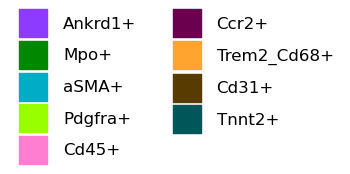

'/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/subset_0.05_wseg/napari_screenshots/pixel_cluster_legend.pdf'

In [47]:
## Iterate over all FOVs
directory = '/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/subset_0.05_wseg'
sample_folder = directory + "/" + "Control_12" + "/"
pixel_categories = pd.read_csv(sample_folder + "population_pixel_mask.csv")
color_palette_use = sns.color_palette(cc.glasbey, n_colors=pixel_categories.shape[0]+1)[1:]

# # Create a new figure and a subplot (which contains the legend)
fig, ax = plt.subplots(figsize=(4, 2))

# # We will use a dummy scatter plot with square markers to create the legend
for (i, label) in enumerate(pixel_categories['region_name']):
    if label != 'background':
        ax.scatter([], [], color=color_palette_use[i], label=label, marker='s', s=400)

# Create the legend
legend = ax.legend(loc='center', title='', fontsize='large', frameon=False, labelspacing=1, ncol=2)

# Hide the axes
ax.axis('off')

# Display the updated figure with square markers
plt.show()

# Save the figure as a PDF file
output_path = "/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/subset_0.05_wseg/napari_screenshots/pixel_cluster_legend.pdf"
fig.savefig(output_path)

output_path


## Pixie code

In [3]:
"""
Save pixel phenotype map TIFs
For each FOV, save 1 TIF where pixel values correspond to pixel cluster id and 1 TIF colored according to pixel cluster id
Must have created mapping file of each pixel cluster to its phenotype

Author: Candace Liu
Date: 8/15/22

"""

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
import scipy.ndimage as ndimage

name = "sigma2_passes10_rep1" #name of file output from pixelClustering.R
clusters_path = "pixelClustering_"+name+"_clusters.csv"
clust_coln = "hCluster_cap" #column name of cluster ids
output_dir = "overlays_pxClusterIDs_"+name #output directory to store overlays
output_dir_colored = "overlays_pxClusterIDs_colored_"+name #output directory to store colored overlays
clust_to_pheno_path = "pixelClustering_"+name+"_mapping.csv" #csv mapping each cluster to its phenotype (must be manually created)
colors_path = "px_colors.csv" #file specifying the colors for each cluster (must be manually created)
size = 1024 #size of image

# Make output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_dir_colored):
    os.makedirs(output_dir_colored)

# Read data
clusters = pd.read_csv(clusters_path, sep=',')
# Point names
points = list(range(1,13))
# Total number of clusters
maxk = max(np.unique(clusters[clust_coln]))

# Get phenotype mapping
clust_to_pheno = pd.read_csv(clust_to_pheno_path)
colors_tab = pd.read_csv(colors_path)
clust_to_color = pd.merge(clust_to_pheno, colors_tab, on='phenotype')
clust_to_color = clust_to_color.sort_values(['hCluster_cap'])

## Create custom cmap
mycols = list(clust_to_color["color"])
mycols.insert(0,'#000000') #first color is black
# Make bounds
bounds = [i-0.5 for i in np.linspace(0,maxk+1,maxk+2)]
colmap = colors.ListedColormap(mycols)
norm = colors.BoundaryNorm(bounds, colmap.N)

# Define function to assign labels
def assign_label(clust_array,x,y,clust):
    clust_array[x,y] = clust

for i in range(len(points)):
    point = points[i]

    # Get cluster data for one point
    samp_clust = clusters.loc[clusters['sample'] == point]

    # Create array for cluster labels, fill with 0's
    clust_array = np.full((size,size), 0, dtype=int)
    # Fill in array
    [assign_label(clust_array,row[0],row[1],row[2]) for row in samp_clust[['x','y',clust_coln]].values]

    # Save overlay as TIF
    im = Image.fromarray(clust_array.astype(np.int32))
    im.save(os.path.join(output_dir, "Point"+str(point)+"_pxClusterIDs.tiff"))

    # Save colored overlay
    image = colmap(norm(clust_array))
    plt.imsave(os.path.join(output_dir_colored, "Point"+str(point)+"_pxClusterIDs_colored.tiff"), image)

    print(point)

# Cell cluster maps

### Using Napari

In [38]:
## The napari way

pixel_img = io.imread("/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/cell_masks_0.05/4h_96/population_cell_mask.tiff")
#mask = io.imread().astype(np.int16)

# Assign each individual label in new_mask the corresponding color value from the color table
pixel_categories = pd.read_csv("/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/cell_masks_0.05/4h_96/population_cell_mask.csv")
color_palette_use = sns.color_palette("colorblind")
color_dict = {0: 'white'}
for region_id in pixel_categories['region_id']:
    #print(f"Region ID: {region_id}, Region Name: {region_name}")
    color_dict[region_id+1] = color_palette_use[region_id]

viewer = napari.Viewer()
viewer.add_labels(pixel_img,color = color_dict)

/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (28356, 30317) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (28356, 30317) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


<Labels layer 'pixel_img' at 0x2f0a8a610>

In [ ]:
## Iterate over all FOVs
directory = '/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/cell_masks_0.05'

for folder in os.listdir(directory):
    if os.path.isdir(os.path.join(directory, folder)) and folder != "napari_screenshots":
        print(folder)
        # Do something with the folder here
        sample_folder = directory + "/" + folder + "/"
        cell_cluster_img = io.imread(sample_folder + "population_cell_mask.tiff")

        # Assign each individual label in new_mask the corresponding color value from the color table
        pixel_categories = pd.read_csv(sample_folder + "population_cell_mask.csv")
        color_palette_use = sns.color_palette(cc.glasbey, n_colors=pixel_categories.shape[0]+1)
        color_dict = {0: 'black'}
        color_dict_legend = {}
        for i,region_id in enumerate(pixel_categories['region_id']):
            if pixel_categories['region_name'][i] == "background":
                color_dict[region_id] = "black"
            else:
                color_dict[region_id] = color_palette_use[i+1]
                color_dict_legend[pixel_categories['region_name'][i]] = color_palette_use[i+1]

        outdir = "/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/cell_masks_0.05/napari_screenshots/"
        outdir_screen = outdir + folder +".cell_clusters.png"

        plot_pixie_maps(pixel_image = cell_cluster_img, sample = folder,mask_color = color_dict,
        scale = 5, screenshot_path = outdir_screen,crop_out_path = outdir)

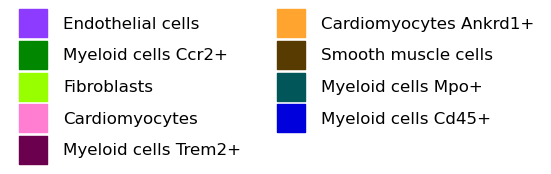

'/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/cell_masks_0.05/napari_screenshots/pixel_cluster_legend.pdf'

In [51]:
## Iterate over all FOVs
directory = '/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/cell_masks_0.05'
sample_folder = directory + "/" + "Control_12" + "/"
pixel_categories = pd.read_csv(sample_folder + "population_cell_mask.csv")
color_palette_use = sns.color_palette(cc.glasbey, n_colors=pixel_categories.shape[0]+1)[1:]

# # Create a new figure and a subplot (which contains the legend)
fig, ax = plt.subplots(figsize=(6, 2))

# # We will use a dummy scatter plot with square markers to create the legend
for (i, label) in enumerate(pixel_categories['region_name']):
    if label != 'background':
        ax.scatter([], [], color=color_palette_use[i], label=label, marker='s', s=400)

# Create the legend
legend = ax.legend(loc='center', title='', fontsize='large', frameon=False, labelspacing=1, ncol=2)

# Hide the axes
ax.axis('off')

# Display the updated figure with square markers
plt.show()

# Save the figure as a PDF file
output_path = "/Users/florian_wuennemann/1_Projects/MI_project/Lunaphore/pixie/masked_subset/cell_masks_0.05/napari_screenshots/pixel_cluster_legend.pdf"
fig.savefig(output_path)

output_path

## Using Pixie Code

In [2]:
## Code modified from : https://github.com/angelolab/publications/blob/main/2022-Liu_etal_Pixie/15_save_cellClusterOverlay_TIFs.py

name = "pixelComposition" #name of output
clusters_path = "cellClustering_kcell14_passes10_cellRep1.csv" #output of cell clustering
clust_to_pheno_path = "cellClustering_kcell14_passes10_cellRep1_mapping_manual.csv" #csv mapping each cluster to its phenotype (must be manually created)

clust_coln = "phenotype_num" #column name of cell cluster ids
seg_dir = "deepcell_output" #segmentation output
output_dir = "overlays_pxCellClusterIDs_"+name #output directory to store overlays
output_dir_colored = "overlays_pxCellClusterIDs_colored_"+name #output directory to store colored overlays
colors_path = "cell_colors.csv" #file specifying the colors for each cluster

# Make output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_dir_colored):
    os.makedirs(output_dir_colored)

# Read data
clusters = pd.read_csv(clusters_path)
# Get manual mapping
clust_to_pheno = pd.read_csv(clust_to_pheno_path)
clusters = pd.merge(clusters, clust_to_pheno, on='pixelfreq_cluster')
# Get colors
colors_tab = pd.read_csv(colors_path)
clusters = pd.merge(clusters, colors_tab, on='phenotype')

# Get points
points = np.unique(clusters['sample'])
maxk = max(np.unique(clusters[clust_coln]))

## Create custom cmap
colors_only = colors_tab[colors_tab['phenotype_num'] <= maxk]
mycols = list(colors_only["color"])
mycols.insert(0,'#000000') #first color is black
mycols.append('#646464') #gray for cells that were not assigned
# Make bounds
bounds = [i-0.5 for i in np.linspace(0,maxk+2,maxk+3)]
colmap = colors.ListedColormap(mycols)
norm = colors.BoundaryNorm(bounds, colmap.N)

for i in range(len(points)):
    point = points[i]

    # Make dictionary of cell label:cluster id
    samp_clust = clusters.loc[clusters['sample'] == point]
    clust_dict = dict(zip(samp_clust['label'],samp_clust[clust_coln]))

    # Get cell segmentation overlay
    label_array = np.array(Image.open(os.path.join(seg_dir, "Point"+str(point)+"_feature_0.tif")))

    # Initialize array with number for unassigned
    pxfreq_cell_array = np.full(label_array.shape,maxk+1)
    # Assign 0s
    pxfreq_cell_array[np.where(label_array==0)] = 0
    # Assign labels
    for lab in clust_dict:
        idx = np.where(label_array == lab)
        pxfreq_cell_array[idx] = clust_dict[lab]

    # Change color of cell borders
    border_array = np.array(Image.open(os.path.join(seg_dir, "Point"+str(point)+"_overlay.tif")))
    white = (border_array==255).all(axis=2)
    border_idx = np.where(white==True)
    pxfreq_cell_array[border_idx] = 0

    # Save overlay as TIF
    im = Image.fromarray(pxfreq_cell_array.astype(np.int32))
    im.save(os.path.join(output_dir, "Point"+str(point)+"_pxCellClusterIDs.tiff"))

    # Save colored overlay
    image = colmap(norm(pxfreq_cell_array))
    plt.imsave(os.path.join(output_dir_colored, "Point"+str(point)+"_pxCellClusterIDs_colored.tiff"), image)

    print(point)

FileNotFoundError: [Errno 2] No such file or directory: 'cellClustering_kcell14_passes10_cellRep1.csv'